<a href="https://colab.research.google.com/github/JairEsc/Aproximaciones-de-Modelos-Epidemiologicos/blob/main/SIS_conteo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# SIS

Se modifica la dinamica de infeccion. Con probabilidad 1 ocurre una transicion $(N-1,1)-----(N-2,2)$, removiendo el unico estado absorbente $(N,0)$, lo que mantiene la dinamica indefinidamente.

In [3]:
def Monte_Carlo_Step_exp_mod(Lambdas,dict_num_contacts,X_I_indexes):
    Lambda=np.sum(Lambdas)
    tau=np.random.exponential(scale=1/Lambda)
    u_2=np.random.uniform(0,1)
    if(len(X_I_indexes)==1):#Se puede acabar
        u_2=0#forzar la infeccion
    if(u_2<(Lambda-Lambdas[-1])/Lambda):#Infeccion
        u_3=np.random.uniform(0,1)
        D=0
        k=0
        while(u_3>D):
            D+=Lambdas[k]/(Lambda-Lambdas[-1])
            k+=1
        new_reaction_index=np.random.choice(range(len(dict_num_contacts[str(k-1)])))
        new_reaction=dict_num_contacts[str(k-1)][new_reaction_index]
    else:#Recuperación--
        k=0
        new_reaction_index=np.random.choice(range(len(X_I_indexes)))
        new_reaction=X_I_indexes[new_reaction_index]
    return tau,new_reaction,k-1,new_reaction_index
def Gillespie_Direct_Method_Network_SIS(beta,gamma,N,X_I_indexes,G_network_initial=nx.Graph(),T=np.inf,Tuto=False):
    flag=True
    #Paso 1.
    t=0 #Inicializar $t=0$.
    #Calcular $k_i$ el número de contactos infecciosos del individuo $i$.--------------------
    counter=0
    X_I=len(X_I_indexes)
    X_S=N-X_I
    Historia=[[0,X_S,X_I]]
    dict_num_contacts = {}
    for n in range(X_I+1):
        dict_num_contacts[str(n)]=[]
    num_cont_inf_por_indice=np.zeros(N)
    for i in G_network_initial.nodes():
        if(i not in X_I_indexes): #No es infeccioso.
            count_for_i=0
            for j in X_I_indexes:
                if (G_network_initial.has_edge(i,j)):#Es un contacto Susceptible-infeccioso.
                    num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                    count_for_i+=1
            dict_num_contacts[str(count_for_i)].append(i)
    hist_N_SI=[[len(list(G_network_initial.neighbors(X_I_indexes[0]))),1]]
    #-------------------------------------------
    while(flag):
        #Generar las Lambdas------------------
        Lambda=0
        Lambdas=[]
        for k in range(int(list(dict_num_contacts.keys())[-1])+1):#Podria no ser continuo? digamos k=0,1,2,5
            k=int(k)
            Lambdas.append((beta/N)*len(dict_num_contacts[str(k)])*k)
            Lambda+=Lambdas[-1]
        Lambdas.append(gamma*X_I)
        Lambda+=Lambdas[-1]
        #-------------------------------------------
        #Paso Monte-Carlo---------------------------
        tau,new_reaction,k_choice,new_reaction_index=Monte_Carlo_Step_exp_mod(Lambdas,dict_num_contacts,X_I_indexes)
        #-------------------------------------------
        #Actualización del sistema.
        if(G_network_initial.nodes[new_reaction]['Estado:']=='Susceptible'):#Se trata de una infección
            X_I+=1
            X_S-=1
            num_cont_inf_por_indice[new_reaction]=0#Una vez que se infecta, ignoramos momentaneamente el número de contactos infecciosos que tenía, pues ya no se puede volver a contagiar.
            G_network_initial.nodes[new_reaction]['Estado:']='Infeccioso'#Actualizar su estado
            X_I_indexes.append(new_reaction)
            i=new_reaction
            dict_num_contacts[str(k_choice)].pop(new_reaction_index)#Saca al nuevo infeccioso del conjunto con exactamente k_choice contactos infecciosos.
            #Para cada nodo
            num_max_cont=int(list(dict_num_contacts.keys())[-1])

            for vecino in G_network_initial.neighbors(i):#Para cada vecino del nuevo infectado, le aumentamos el numero de contactos en 1. (lo agregamos a la siguiente categoria y lo sacamos de la anterior)
                if (G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):
                    num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                    if(num_cont_del_vecino+1>num_max_cont):#Si mas de uno crea una categoria, hay error. Pero ya está arreglado.
                        num_max_cont+=1
                        dict_num_contacts[str(int(num_cont_del_vecino+1))]=[vecino]
                    else:
                        dict_num_contacts[str(int(num_cont_del_vecino+1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)# remove es con busqueda
                    num_cont_inf_por_indice[vecino]+=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        else:# Paso de infeccioso a susceptible otra vez.
            X_I-=1
            X_S+=1
            G_network_initial.nodes[new_reaction]['Estado:']='Susceptible'
            #------------------ Volvemos a contar sus contactos infecciosos.
            num_cont_inf_por_indice[new_reaction]=0
            for neig in G_network_initial.neighbors(new_reaction):
                if(G_network_initial.nodes[neig]['Estado:']=='Infeccioso'):
                    num_cont_inf_por_indice[new_reaction]+=1
            #-------------------
            X_I_indexes.pop(new_reaction_index)#Lo saca de infecciosos
            #----------------- Lo volvemos a ubicar en susceptibles
            num_max_cont=int(list(dict_num_contacts.keys())[-1])
            if(num_cont_inf_por_indice[new_reaction]>num_max_cont):#Si mas de uno crea una categoria, hay error.
                for dif in range(num_max_cont+1,int(num_cont_inf_por_indice[new_reaction]+1)):
                    dict_num_contacts[str(dif)]=[]
                dict_num_contacts[str(int(num_cont_inf_por_indice[new_reaction]))]=[new_reaction]
            else:
                dict_num_contacts[str(int(num_cont_inf_por_indice[new_reaction]))].append(new_reaction)
            #-----------------
            i=new_reaction
            #print(i, "es el que se va a recuperar")
            #----------------- Actualizamos el numero de contactos de sus vecinos.
            for vecino in G_network_initial.neighbors(i):#Podria ser que ya no tuviera ningun contacto
                #print("estoy en el vecino ",vecino," con estatus: ",G_network_initial.nodes[vecino]['Estado:'])
                num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                if(G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):
                    dict_num_contacts[str(int(num_cont_del_vecino-1))].append(vecino)#Actualizamos el numero de contactos infecciones en -1
                    #print("lo intento quitar del conjunto de ",num_cont_del_vecino, " vecinos infecciosos. i.e.", dict_num_contacts[str(int(num_cont_del_vecino))])
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]-=1#Actualizamos ambas fuentes de informacion

            #-------------------------------------------
        t+=tau #Actualiza el tiempo
        if Tuto:
            print("Se genera el tiempo ",tau)
            print("Se selecciona al individuo",i)
            print("infectado por estar en el grupo con ", k_choice)
            nx.draw(G=G_network_initial,node_color=['green' if G_network_initial.nodes[i]['Estado:']=='Susceptible' else 'red' if G_network_initial.nodes[i]['Estado:']=='Infeccioso' else 'gray' for i in G.nodes()],with_labels=True)
            plt.show()
        X_I=len(X_I_indexes)
        X_S=N-X_I
        N_SI=int(np.sum(num_cont_inf_por_indice))
        hist_N_SI.append([N_SI,X_I])
        Historia.append([t,X_S,X_I])#Focus
        counter+=1
        if(X_I==0 or len(Historia)==T):
            flag=False
    return Historia,hist_N_SI

# Exploración del número de aristas promedio vs. la aproximación asumiendo uniformidad de la distribución de infecciosos sobre la gráfica

$$N_{SI}(k)=k\frac{N-k}{N}n$$
y
$$\hat{N}_{SI}(k)=k\frac{N-k}{N-1}p(N-1)$$


### Caso 1 Usando G(N,p), $p= 0.1$, N=21. Debería ser parecida a una 2-regular.

[15]
Empieza
1000000
time:  94.75246953964233


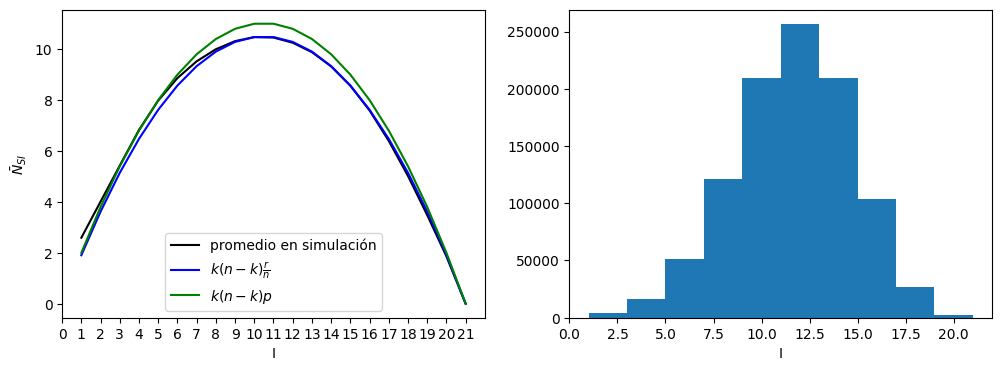

[15, 10, 3, 18, 17, 14, 16, 4, 2, 6]
Empieza
1000000
time:  103.51600861549377


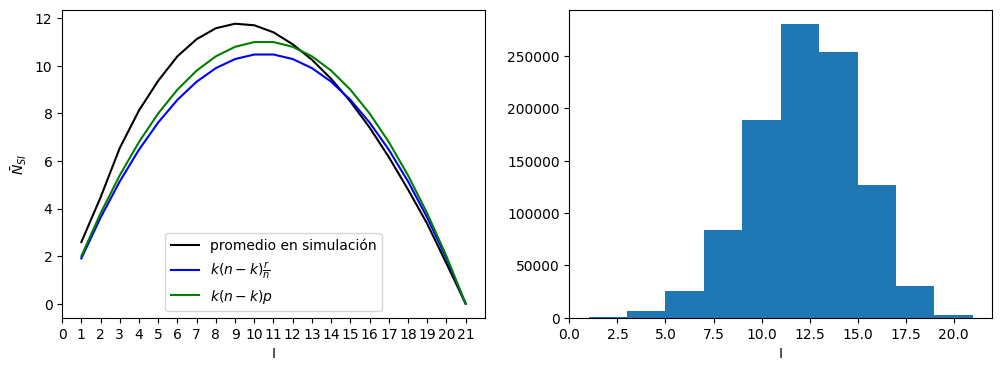

In [31]:
N=21
n=2
for i_0 in range(1,3):
  np.random.seed(1)
  import time
  start_=time.time()
  fig = plt.figure(figsize=(12,4))
  plt.subplot(1,2,1)
  G=nx.gnp_random_graph(n=N,p=n/(N-1))
  G=nx.convert_node_labels_to_integers(G,ordering='default',)
  while(nx.is_connected(G)==False):#Generar una gráfica conexa
      N=21
      n=2
      G=nx.gnp_random_graph(n=N,p=n/(N-1))
      G=nx.convert_node_labels_to_integers(G,ordering='default',)
  X_I_indexes=np.random.choice(N,[1,int(N/2)][i_0-1],replace=False).tolist()
  print(X_I_indexes)
  for k in range(N):
      if k in X_I_indexes:
          G.nodes[k]['Estado:']='Infeccioso'
      else:
          G.nodes[k]['Estado:']='Susceptible'
  G_copy=G.copy()
  print("Empieza")
  H,conteo=Gillespie_Direct_Method_Network_SIS(beta=1.15*N,gamma=1,N=N,X_I_indexes=X_I_indexes,G_network_initial=G_copy,T=10**6,Tuto=False)
  print(len(H))
  print("time: ", time.time()-start_)
  conteo_data=pd.DataFrame(conteo,columns=['N_SI','k'])
  conteo_promedio=conteo_data.groupby(['k']).mean()
  r=[]
  r2=[]
  for i in range(1,len(conteo_promedio)+1):
      r.append(i*((N-i)/N)*n)
      r2.append(i*(N-i)*n/(N-1))
  conteo_promedio['approx']=r
  conteo_promedio['approx_2']=r2
  for i in range(0,3):
      plt.plot(conteo_promedio[conteo_promedio.keys()[i]],color='kbg'[i])
  plt.legend(['promedio en simulación',r'$k(n-k)\frac{r}{n}$','$k(n-k)p$'])
  plt.xticks(range(0,22))
  plt.xlabel('I')
  plt.ylabel(r'$\bar{N}_{SI}$')
  #plt.savefig('SIS_edges_a.png',dpi=300)
  plt.subplot(1, 2, 2)
  plt.hist(conteo_data['k'])
  plt.xlabel('I')
  plt.show()

### Caso 2. Usando una regular estricta. $N=21$, $n=2$

[15]
Empieza
100000
time:  9.492311477661133


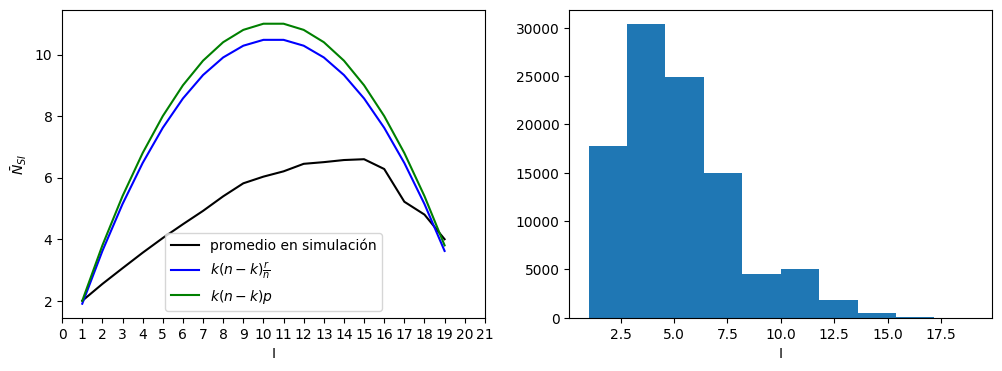

[15, 10, 3, 18, 17, 14, 16, 4, 2, 6]
Empieza
100000
time:  10.444761514663696


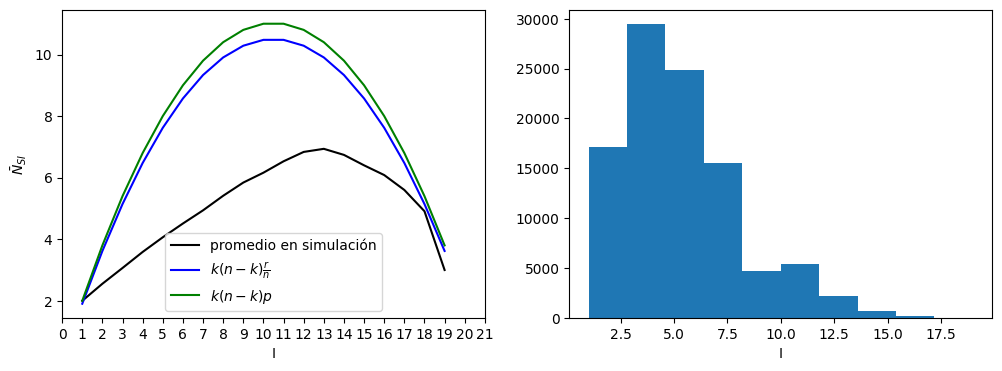

In [33]:
N=21
n=2
for i_0 in range(1,3):
  np.random.seed(1)
  import time
  start_=time.time()
  fig = plt.figure(figsize=(12,4))
  plt.subplot(1,2,1)
  G=nx.random_regular_graph(d=n,n=N)
  G=nx.convert_node_labels_to_integers(G,ordering='default',)
  while(nx.is_connected(G)==False):#Asegurarme que salga una gráfica conexa
      N=21
      n=2
      G=nx.random_regular_graph(d=n,n=N)
      G=nx.convert_node_labels_to_integers(G,ordering='default',)
  X_I_indexes=np.random.choice(N,[1,int(N/2)][i_0-1],replace=False).tolist()
  print(X_I_indexes)
  for k in range(N):
      if k in X_I_indexes:
          G.nodes[k]['Estado:']='Infeccioso'
      else:
          G.nodes[k]['Estado:']='Susceptible'
  G_copy=G.copy()
  print("Empieza")
  H,conteo=Gillespie_Direct_Method_Network_SIS(beta=1.15*N,gamma=1,N=N,X_I_indexes=X_I_indexes,G_network_initial=G_copy,T=10**5,Tuto=False)
  print(len(H))
  print("time: ", time.time()-start_)
  conteo_data=pd.DataFrame(conteo,columns=['N_SI','k'])
  conteo_promedio=conteo_data.groupby(['k']).mean()
  r=[]
  r2=[]
  for i in range(1,len(conteo_promedio)+1):
      r.append(i*((N-i)/N)*n)
      r2.append(i*(N-i)*n/(N-1))
  conteo_promedio['approx']=r
  conteo_promedio['approx_2']=r2
  for i in range(0,3):
      plt.plot(conteo_promedio[conteo_promedio.keys()[i]],color='kbg'[i])
  plt.legend(['promedio en simulación',r'$k(n-k)\frac{r}{n}$','$k(n-k)p$'])
  plt.xticks(range(0,22))
  plt.xlabel('I')
  plt.ylabel(r'$\bar{N}_{SI}$')
  #plt.savefig('SIS_edges_a.png',dpi=300)
  plt.subplot(1, 2, 2)
  plt.hist(conteo_data['k'])
  plt.xlabel('I')
  plt.show()

## Caso 1. Gráfica 2-regular, de orden $\mathcal{O}(10^3)$.

[507]
Empieza
100000
time:  9.635499238967896


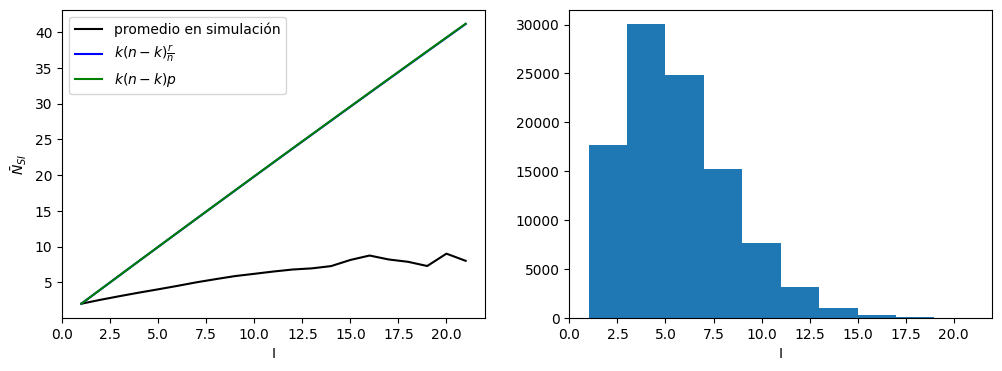

[507, 818, 452, 368, 242, 929, 262, 810, 318, 49, 446, 142, 968, 345, 971, 133, 104, 6, 600, 496, 702, 472, 598, 502, 433, 119, 108, 647, 589, 374, 910, 718, 744, 494, 404, 274, 78, 721, 644, 614, 872, 691, 90, 101, 94, 577, 537, 41, 453, 995, 713, 34, 639, 35, 148, 455, 885, 677, 486, 685, 307, 238, 395, 734, 822, 812, 464, 816, 528, 17, 709, 370, 241, 964, 457, 65, 191, 838, 331, 638, 255, 742, 756, 757, 951, 992, 463, 843, 573, 527, 654, 189, 517, 956, 414, 671, 559, 593, 258, 154, 335, 13, 911, 156, 428, 824, 267, 538, 236, 944, 479, 785, 950, 59, 868, 175, 711, 449, 120, 794, 180, 311, 3, 194, 437, 683, 799, 746, 625, 692, 551, 248, 659, 2, 997, 860, 776, 857, 358, 769, 73, 117, 938, 535, 111, 509, 512, 916, 555, 552, 354, 970, 8, 581, 56, 576, 705, 651, 84, 228, 159, 205, 125, 688, 887, 473, 244, 597, 797, 195, 202, 81, 484, 443, 578, 201, 186, 516, 821, 967, 216, 50, 783, 672, 531, 314, 200, 223, 587, 983, 699, 826, 233, 584, 974, 430, 874, 550, 608, 207, 382, 994, 982, 47, 521,

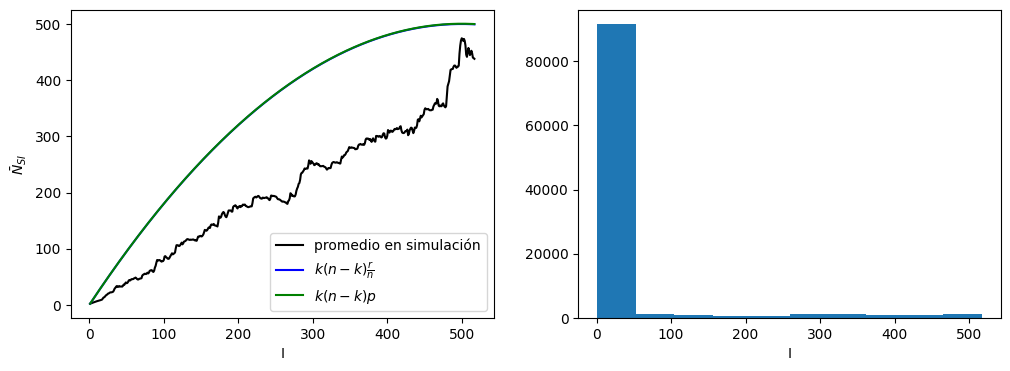

In [36]:
N=1000
n=2
for i_0 in range(1,3):
  np.random.seed(1)
  import time
  start_=time.time()
  fig = plt.figure(figsize=(12,4))
  plt.subplot(1,2,1)
  G=nx.random_regular_graph(n,N)
  G=nx.convert_node_labels_to_integers(G,ordering='default',)
  while(nx.is_connected(G)==False):
      N=1000
      n=2
      G=nx.random_regular_graph(n,N)
      G=nx.convert_node_labels_to_integers(G,ordering='default',)
  X_I_indexes=np.random.choice(N,[1,int(N/2)][i_0-1],replace=False).tolist()
  print(X_I_indexes)
  for k in range(N):
      if k in X_I_indexes:
          G.nodes[k]['Estado:']='Infeccioso'
      else:
          G.nodes[k]['Estado:']='Susceptible'
  G_copy=G.copy()
  print("Empieza")
  H,conteo=Gillespie_Direct_Method_Network_SIS(beta=1.15*N,gamma=1,N=N,X_I_indexes=X_I_indexes,G_network_initial=G_copy,T=10**5,Tuto=False)
  print(len(H))
  print("time: ", time.time()-start_)
  conteo_data=pd.DataFrame(conteo,columns=['N_SI','k'])
  conteo_promedio=conteo_data.groupby(['k']).mean()
  r=[]
  r2=[]
  for i in range(1,len(conteo_promedio)+1):
      r.append(i*((N-i)/N)*n)
      r2.append(i*(N-i)*n/(N-1))
  conteo_promedio['approx']=r
  conteo_promedio['approx_2']=r2
  for i in range(0,3):
      plt.plot(conteo_promedio[conteo_promedio.keys()[i]],color='kbg'[i])
  plt.legend(['promedio en simulación',r'$k(n-k)\frac{r}{n}$','$k(n-k)p$'])
  #plt.xticks(range(0,22))
  plt.xlabel('I')
  plt.ylabel(r'$\bar{N}_{SI}$')
  #plt.savefig('SIS_edges_a.png',dpi=300)
  plt.subplot(1, 2, 2)
  plt.hist(conteo_data['k'])
  plt.xlabel('I')
  plt.show()


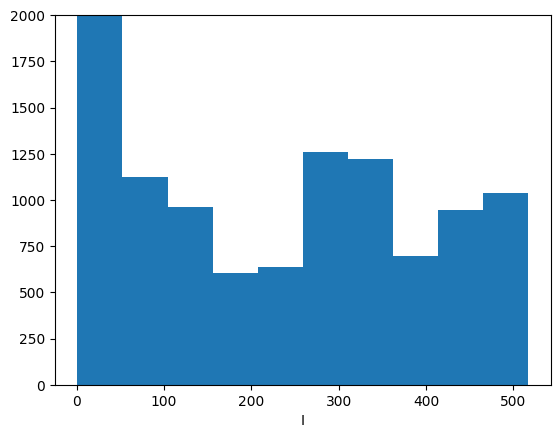

In [40]:
plt.hist(conteo_data['k'])
plt.xlabel('I')
plt.ylim((0,2000))
plt.show()

### Caso 2.1. Gráfica G(N,p), N=1000, $p=2/1000$.

[993]
Empieza
100000
time:  18.241910219192505


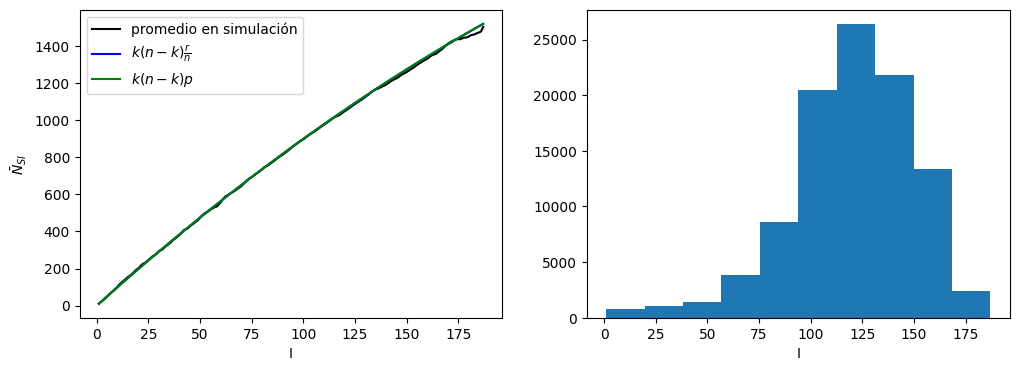

In [54]:
N=1000
n=10
for i_0 in range(1,2):
  np.random.seed(0)
  import time
  start_=time.time()
  fig = plt.figure(figsize=(12,4))
  plt.subplot(1,2,1)
  G=nx.fast_gnp_random_graph(n=N,p=n/N)
  G=nx.convert_node_labels_to_integers(G,ordering='default',)
  while(nx.is_connected(G)==False):
      G=nx.fast_gnp_random_graph(n=N,p=n/N)
      G=nx.convert_node_labels_to_integers(G,ordering='default',)
  X_I_indexes=np.random.choice(N,[1,int(N/2)][i_0-1],replace=False).tolist()
  print(X_I_indexes)
  for k in range(N):
      if k in X_I_indexes:
          G.nodes[k]['Estado:']='Infeccioso'
      else:
          G.nodes[k]['Estado:']='Susceptible'
  G_copy=G.copy()
  print("Empieza")
  H,conteo=Gillespie_Direct_Method_Network_SIS(beta=1.15*N/n,gamma=1,N=N,X_I_indexes=X_I_indexes,G_network_initial=G_copy,T=10**5,Tuto=False)
  print(len(H))
  print("time: ", time.time()-start_)
  conteo_data=pd.DataFrame(conteo,columns=['N_SI','k'])
  conteo_promedio=conteo_data.groupby(['k']).mean()
  r=[]
  r2=[]
  for i in range(1,len(conteo_promedio)+1):
      r.append(i*((N-i)/N)*n)
      r2.append(i*(N-i)*n/(N-1))
  conteo_promedio['approx']=r
  conteo_promedio['approx_2']=r2
  for i in range(0,3):
      plt.plot(conteo_promedio[conteo_promedio.keys()[i]],color='kbg'[i])
  plt.legend(['promedio en simulación',r'$k(n-k)\frac{r}{n}$','$k(n-k)p$'])
  #plt.xticks(range(0,22))
  plt.xlabel('I')
  plt.ylabel(r'$\bar{N}_{SI}$')
  #plt.savefig('SIS_edges_a.png',dpi=300)
  plt.subplot(1, 2, 2)
  plt.hist(conteo_data['k'])
  plt.xlabel('I')
  plt.show()
